# Census population changes

## What we're trying to recreate

[[source]](https://www.washingtonpost.com/nation/interactive/2021/census-population-changes/)

The visualisation on the Washington Post's website displays a parallel coordinate plot of the United States to illustrate population changes in each state between 2010 and 2020, as reported by the 2020 Census. The lines are color coded, so an increase is purple, a decrease orange and steady state is grey.

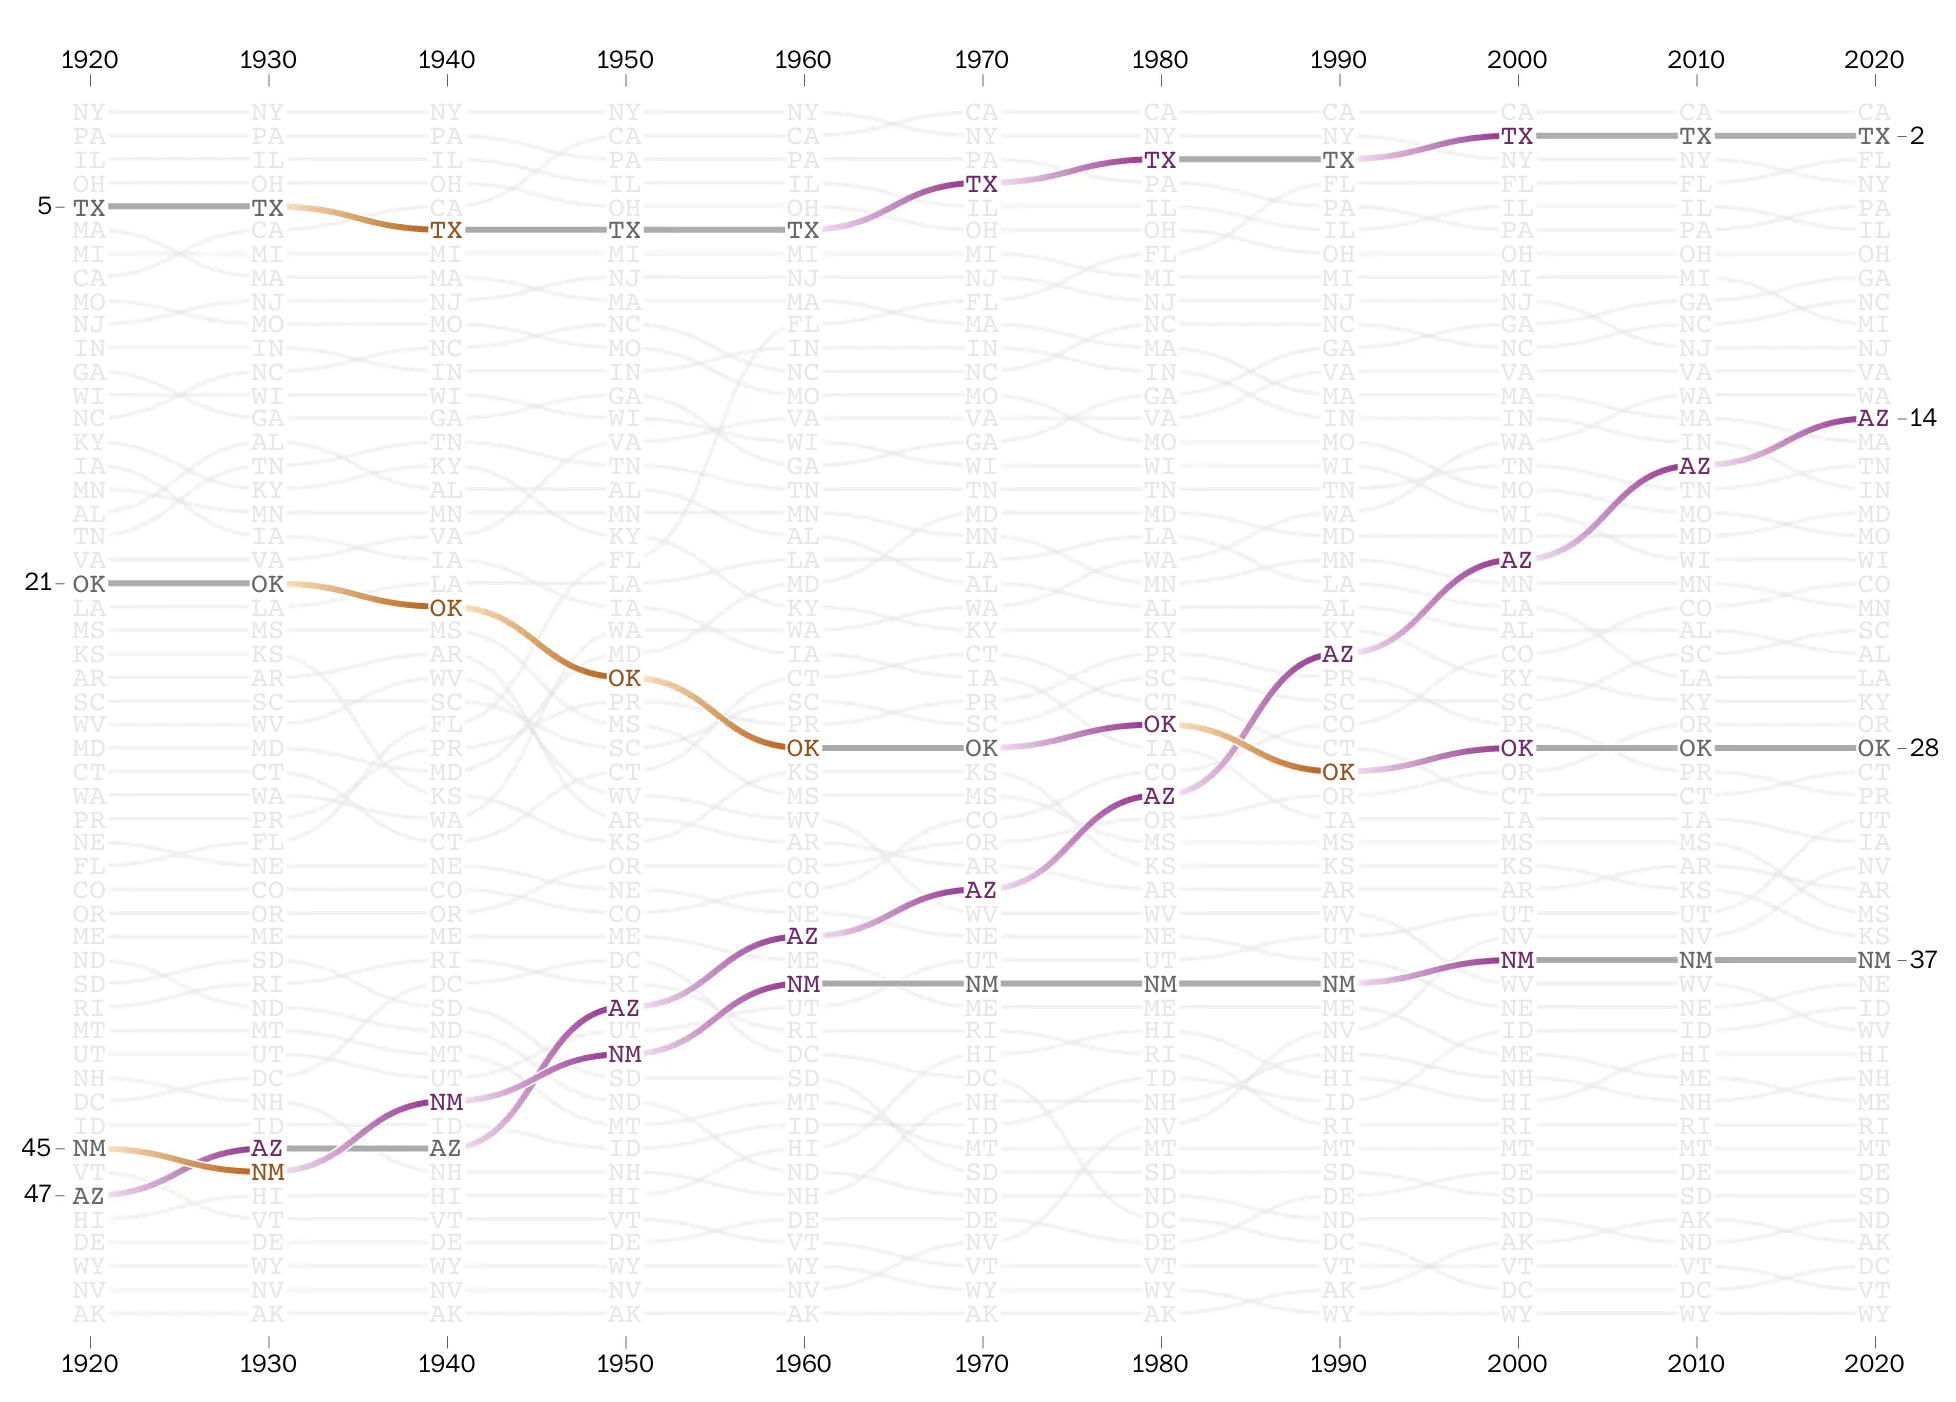

In [1]:
from IPython.display import Image
Image(filename="viz.png", retina=True)

## Setup

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib_inline.backend_inline
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from dataclasses import dataclass

In [3]:
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

In [4]:
plt.rcParams["font.family"] = "Arial"

In [5]:
df_census = pd.read_csv("data.txt", delimiter="\t")

## Helper functions

In [6]:
def interpolate_decades(x, y):
    kind = "quadratic"

    min_year, max_year = x
    min_pos, max_pos = y

    num_interpolation = 500
    correction_year = 2.5
    span_pos = max_pos - min_pos
    correction_pos = span_pos / 10
    
    change = "status quo" if span_pos == 0 else "increase" if span_pos < 0 else "decrease"

    cubic_interpolation_model = interp1d(
        x=(min_year, min_year + correction_year, max_year - correction_year, max_year),
        y=(min_pos, min_pos + correction_pos, max_pos - correction_pos, max_pos),
        kind=kind,
    )

    X_ = np.linspace(min_year, max_year, num_interpolation)
    Y_ = cubic_interpolation_model(X_)

    return {"x": x, "y": y, "x_interpolated": X_, "y_interpolated": Y_, "change": change}

In [7]:
def transform_grouped_df(df):
    return [interpolate_decades((y1, y2), (p1, p2)) for y1, y2, p1, p2 in zip(df.year, df.year[1:], df.pos, df.pos[1:])]

## Data preparation

In [8]:
data_transformed = {}
for state, df in df_census.groupby("state"):
    data_transformed[state] = transform_grouped_df(df)

In [9]:
len(data_transformed.keys())

52

In [10]:
data_transformed.keys()

dict_keys(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'])

In [11]:
len(data_transformed.get("TX"))

10

In [12]:
data_transformed.get("TX")[0].keys()

dict_keys(['x', 'y', 'x_interpolated', 'y_interpolated', 'change'])

In [13]:
data_transformed.get("TX")[0]

{'x': (1920, 1930),
 'y': (5, 5),
 'x_interpolated': array([1920.        , 1920.02004008, 1920.04008016, 1920.06012024,
        1920.08016032, 1920.1002004 , 1920.12024048, 1920.14028056,
        1920.16032064, 1920.18036072, 1920.2004008 , 1920.22044088,
        1920.24048096, 1920.26052104, 1920.28056112, 1920.3006012 ,
        1920.32064128, 1920.34068136, 1920.36072144, 1920.38076152,
        1920.4008016 , 1920.42084168, 1920.44088176, 1920.46092184,
        1920.48096192, 1920.501002  , 1920.52104208, 1920.54108216,
        1920.56112224, 1920.58116232, 1920.6012024 , 1920.62124248,
        1920.64128257, 1920.66132265, 1920.68136273, 1920.70140281,
        1920.72144289, 1920.74148297, 1920.76152305, 1920.78156313,
        1920.80160321, 1920.82164329, 1920.84168337, 1920.86172345,
        1920.88176353, 1920.90180361, 1920.92184369, 1920.94188377,
        1920.96192385, 1920.98196393, 1921.00200401, 1921.02204409,
        1921.04208417, 1921.06212425, 1921.08216433, 1921.102204

## Settings, options and colors

In [14]:
@dataclass
class TextColors:
    basic: str = "darkgray"
    increase: str = "#732569"  # purple
    decrease: str = "#9F4C00"  # orange
    status_quo: str = "#666666"  # dark gray

@dataclass
class PlotColors:
    basic: str = "darkgray"
    increase: str = "#A83B9E"  # purple, a little ligther than text
    decrease: str = "#CD6306"  # orange, a little ligther than text
    status_quo: str = "#AAAAAA"  # dark gray, a little ligther than text
    
txtclrs = TextColors()
pltclrs = PlotColors()
    
text_high_clr = {
    "increase": txtclrs.increase,
    "decrease": txtclrs.decrease,
    "status quo": txtclrs.status_quo,
}

def create_cmap(color):
    return mcolors.LinearSegmentedColormap.from_list("custom", ["white", color])

cmaps = {
    "increase": create_cmap(pltclrs.increase),
    "decrease": create_cmap(pltclrs.decrease),
}

In [15]:
box = {
    "facecolor": "white",
    "linewidth": 0,
    "pad": 0.5,
    "capstyle": "round",
}

# Define the common key-value pairs for font markers
font_common = {
    "family": "monospace",
    "name": "Courier",
    "size": 10,
}

# Define the specific key-value pairs for basic font markers
font_basic = {
    "color": txtclrs.basic,
    "weight": "normal",
    "alpha": 0.3,
}

# Define the specific key-value pairs for high font markers
font_high = {
    "color": txtclrs.status_quo,
    "weight": "bold",
}

# Update the specific dictionaries with the common values
font_basic.update(font_common)
font_high.update(font_common)

state_marker_base = {
    "fontdict": font_basic,
    "bbox": box,
}

state_marker_high = {
    "fontdict": font_high,
    "bbox": box,
}

state_marker_high_clr = {
    "antialiased": True,
    "marker": "o",
    "markersize": 2.5,
    "markeredgecolor": "none",
}

line_base = {
    "antialiased": True,
    "alpha": 0.15,
    "color": txtclrs.basic,
    "linewidth": 1.5,
}

line_high = {
    "antialiased": True,
    "linewidth": 2.5,
}

line_high_bg = {
    "antialiased": True,
    "linewidth": 4.0,
    "color": "white",
}

ticks_options = {
    "width": 0.25,
    "pad": 1,
}

## Makeover

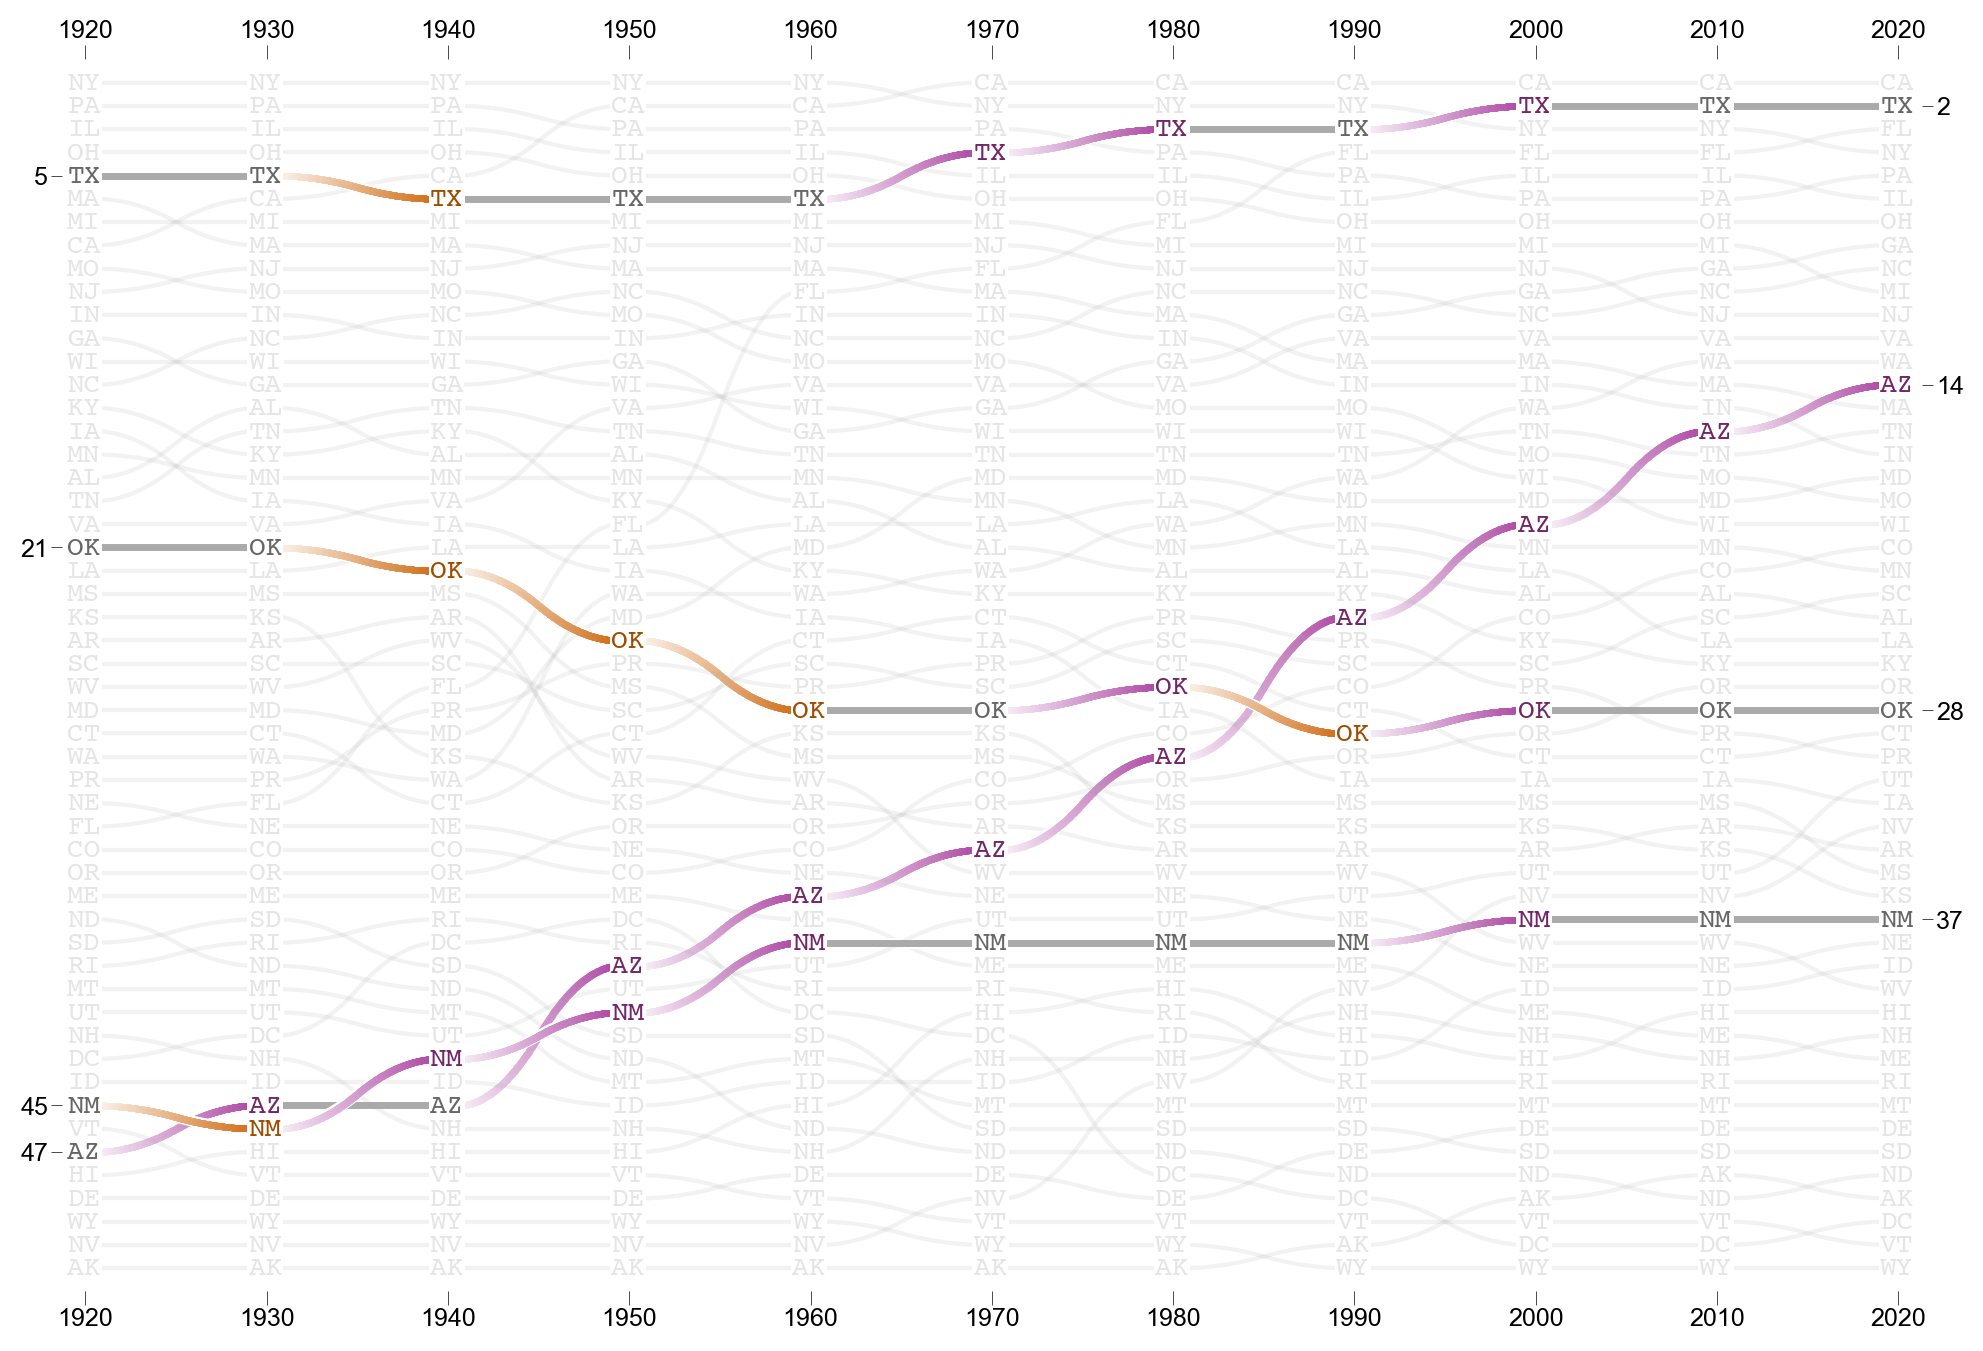

In [16]:
highlight = {"TX", "OK", "NM", "AZ"}
year_cor = - 1
pos_cor = 0.3

years = range(1920, 2021, 10)

fig, ax = plt.subplots(figsize=(12, 8))

y1_ticks = []
y2_ticks = []

for state, data in data_transformed.items():

    if state in highlight:
        initial_pos = data[0].get("y")[0]
        final_pos = data[-1].get("y")[1]
        y1_ticks.append(initial_pos)
        y2_ticks.append(final_pos)

    for i, decade in enumerate(data):
        x = decade["x_interpolated"]
        y = decade["y_interpolated"]
        year_right, pos_right = decade["x"][1] + year_cor, decade["y"][1] + pos_cor
        change = decade["change"]

        if i == 0:
            year_left, pos_left = decade["x"][0] + year_cor, decade["y"][0] + pos_cor
            ax.text(year_left, pos_left, state, **(state_marker_high if state in highlight else state_marker_base))

        if state in highlight:
            ax.plot(x, y, **line_high_bg)
            if change in {"increase", "decrease"}:
                for j, (x_, y_) in enumerate(zip(x, y)):
                    ax.plot(x_, y_, markerfacecolor=cmaps[change](j/len(x)), **state_marker_high_clr)
            else:
                ax.plot(x, y, color=pltclrs.status_quo, **line_high)

            ax.text(year_right, pos_right, state, color = text_high_clr[change], **state_marker_high)
        else:
            ax.plot(x, y, **line_base)
            ax.text(year_right, pos_right, state, **state_marker_base)

# Set limits
ax.set_ylim(53, 0)

# Fetch primary y-axis
y1 = ax.get_yaxis()

# Add secondary y-axis
y2 = ax.secondary_yaxis("right")
y2.tick_params(length=4, labelsize=9, **ticks_options)
y2.spines["right"].set_visible(False)

# Add tick marks for highlighted states and x-axis
y1.set_ticks(y1_ticks)
y2.set_ticks(y2_ticks)
ax.set_xticks(years)

ax.margins(x=0.013)
ax.tick_params(top=True, labeltop=True, labelsize=9)
ax.tick_params(axis="x", length=5, **ticks_options)
ax.tick_params(axis="y", length=4, **ticks_options)

for _, spine in ax.spines.items():
    spine.set_visible(False)

In [17]:
fig.savefig("viz_makeover.png", dpi=200, bbox_inches="tight")